<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 : West Nile Virus Prediction
### Notebook 2 of 4: Feature Engineering

## Contents:
- [Import Libraries](#Import-Libraries)
- [Define functions](#Define-functions)
- [Import data from Pickle](#Import-data-from-Pickle)
- [Feature Engineering](#Feature-Engineering)
- [Pickle data](#Pickle-data)

# Import Libraries
*Back to [Contents](#Contents:)*

In [1]:
# Imports:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.cluster import KMeans

import lightgbm as lgb

import pickle

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

get_ipython().run_line_magic('matplotlib', 'inline')

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd

import datetime

In [2]:
#steps to install geopandas

#!pip install pipwin
#!pipwin install gdal
#!pipwin install fiona
#!pip install geopandas
#!pipwin install rasterio
#!pip install contextily

In [3]:
#!pip install imblearn

In [4]:
#!pip install lightgbm

## Define functions
- get_weather_data (takes in weather station number, flag, weather feature, lag and return result based on flag)
- add_weather_features (add in numeric weather features to either the train or test data)
- distance (to calculate distance between two coordinates)
- near_station (applied to a dataframe to determine if a location is nearer to Station 1 or 2)

*Back to [Contents](#Contents:)*

In [5]:
def get_weather_data(station =1, # station ID
                     flag = 1,  # 1: shift, 2: rolling avg, 3: rolling max
                     feature = None, 
                     k=0 # lagged days
                    ):
    
    # if lagged days == 0, just return the feature data directly
    if k == 0:
        if station == 1 :
            return df_weather_1[feature]
        else:
            return df_weather_2[feature]
    else:
        if flag == 1: # shift the feature, and return the result column
             if station == 1 :
                return df_weather_1[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
             else:
                return df_weather_2[feature].shift(k).rename(columns={feature[0]:f'{feature[0]}-{k}'})
            
        elif flag == 2: # averge the feature in a rolling period and return the result column 
             if station == 1 :
                return df_weather_1[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
             else:
                return df_weather_2[feature].rolling(k).mean().rename(columns={feature[0]:f'{feature[0]}-avg-{k}'})
            
        elif flag == 3: # find the max value of the feature in a rolling period and return the result column
             if station == 1 :
                return df_weather_1[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})
             else:
                return df_weather_2[feature].rolling(k).max().rename(columns={feature[0]:f'{feature[0]}-max-{k}'})

In [6]:
def add_weather_features(df, 
                         weather_features_shift=None,  #dictionary
                         weather_features_avg=None,
                         weather_features_max=None
                        ):
    df['id_'] = df.index
    df1 = df.query("Station==1")
    df2 = df.query("Station==2")
    
    features_numeric_weather = ["Tmax","Tmin","Tavg",'DewPoint',"Sunrise",
                                 "Sunset",'Day_length','PrecipTotal','ResultSpeed']                       
                             
    df1 = pd.merge(df1, df_weather_1[features_numeric_weather],on='Date',how='inner')
    df2 = pd.merge(df2, df_weather_2[features_numeric_weather],on='Date',how='inner')
    
    if weather_features_shift !=None:
        for key, value in weather_features_shift.items():
            result_feature_column_1 = get_weather_data(1,1,[key],value)
            df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')

            result_feature_column_2 = get_weather_data(2,1,[key],value)
            df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')

    if weather_features_avg !=None:
        for key, value in weather_features_avg.items():
            result_feature_column_1 = get_weather_data(1,2,[key],value)
            df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')

            result_feature_column_2 = get_weather_data(2,2,[key],value)
            df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')
            
    if weather_features_max !=None:
        for key, value in weather_features_max.items():
            result_feature_column_1 = get_weather_data(1,3,[key],value)
            df1 = pd.merge(df1,result_feature_column_1,on='Date',how='inner')

            result_feature_column_2 = get_weather_data(2,3,[key],value)
            df2 = pd.merge(df2,result_feature_column_2,on='Date',how='inner')

    df_final = pd.concat([df1, df2], sort=False)
    df_final.set_index('id_', drop=True, inplace=True)
    df_final.sort_index(inplace=True)

    return  df_final

In [7]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

**Reference for distance function above**: https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth<br>
(Python 3 program to calculate Distance Between Two Points on Earth)

In [8]:
# the function will find if a location is nearer to Station 1 or 2
# it is to be used in dataframe.apply()

def near_station(row  # a row of record in a dataframe
                ):
    lat = row['Latitude']
    lon = row['Longitude']
    station1_lat = 41.995
    station1_lon = -87.933
    station2_lat = 41.786
    station2_lon = -87.752
    
    if distance(lat, station1_lat, lon, station1_lon) < distance(lat, station2_lat, lon, station2_lon):
        return 1
    else:
        return 2

# Import data from Pickle
*Back to [Contents](#Contents:)*

In [9]:
# read pickle_dict, which stores everything from previous notebook

pickle_dict1 = pickle.load(open('./assets/data1.pkl', 'rb'))
df_train = pickle_dict1['df_train']
df_test = pickle_dict1['df_test']
df_spray = pickle_dict1['df_spray']
df_weather_1 = pickle_dict1['df_weather_1']
df_weather_2 = pickle_dict1['df_weather_2']

# Feature Engineering
- Species: 
    - All species which do not carry the West Nile Virus will be regrouped to 'OTHERS'
    - Convert the categorical feature of Species into dummy variables
<br>
- Traps:
    - Cluster all traps based on their locations to simplify analysis (we will try with 30 clusters)
    - Convert this categorical feature of Trap Clusters into dummy variables
<br>    
- Weather data
    - To decide on transformation of weather features: whether to shift, apply rolling-mean or rolling-max
    - Once transformation is done, add those weather features to Train set
    
 *Back to [Contents](#Contents:)*

### Feature engineering on Species
- All species which do not carry the West Nile Virus will be regrouped to 'OTHERS'
- Convert the categorical feature of Species into dummy variables

In [10]:
# define a list of mosquito species to keep
species_to_keep = ['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS']

# for Train data
df_train.loc[:,['Species']] = np.where(df_train['Species'].isin(species_to_keep), df_train['Species'], 'OTHERS')

# for Test submission
df_test.loc[:,['Species']] = np.where(df_test['Species'].isin(species_to_keep), df_test['Species'], 'OTHERS')

In [11]:
# for Train data
df_train = pd.get_dummies(columns=["Species"], data=df_train, drop_first=True)

# for Test submission
df_test = pd.get_dummies(columns=["Species"], data=df_test, drop_first=True)

### Feature engineering on Trap locations
- Cluster all traps based on their locations to simplify analysis (we will try with 30 clusters)
- Convert this categorical feature of Trap Clusters into dummy variables

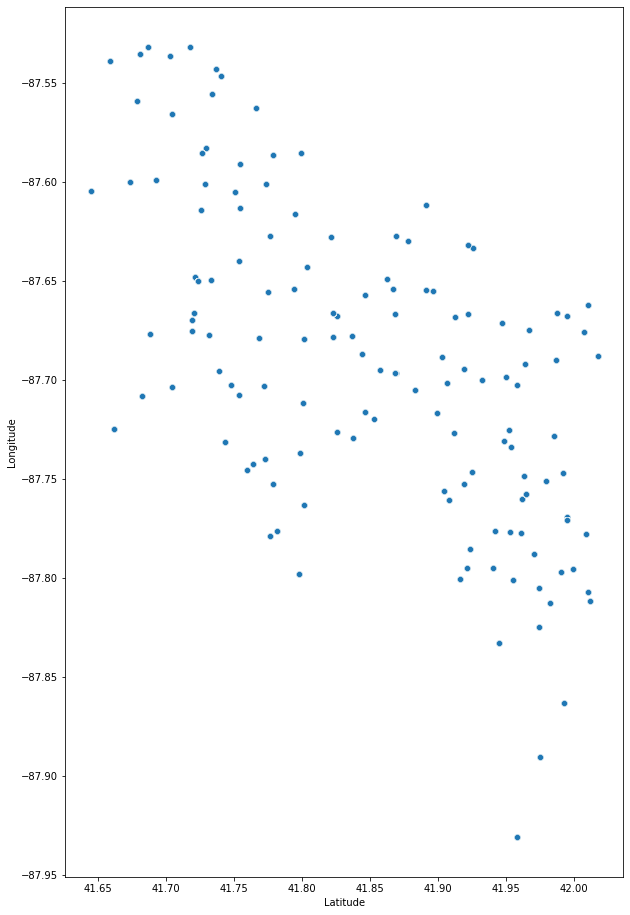

In [12]:
# plot all traps locations
fig, ax = plt.subplots(1, figsize=(10,16))
sns.scatterplot(data=df_train, x='Latitude', y='Longitude', palette="muted");

In [13]:
# Prepare X matrix
X = df_train.loc[:, ['Latitude', 'Longitude']]

# for Test submission
X_test = df_test.loc[:, ['Latitude', 'Longitude']]

In [14]:
# Instatiate KMeans clustering with 30 clusters
km = KMeans(n_clusters=30, random_state=42)

# Fit our train set to KMeans algorithm
km.fit(X)

KMeans(n_clusters=30, random_state=42)

In [15]:
# Check out the cluster centroids
km.cluster_centers_

array([[ 41.97671976, -87.74650368],
       [ 41.76410356, -87.60413316],
       [ 41.9764036 , -87.88795283],
       [ 41.81609879, -87.6731264 ],
       [ 41.72610751, -87.65870889],
       [ 41.692987  , -87.562828  ],
       [ 41.89336897, -87.654814  ],
       [ 41.91287139, -87.74556978],
       [ 41.78789927, -87.76624012],
       [ 41.95935416, -87.80618051],
       [ 41.99959506, -87.67910765],
       [ 41.662014  , -87.724608  ],
       [ 41.72694528, -87.58945653],
       [ 41.80955606, -87.72762192],
       [ 41.67338941, -87.59995427],
       [ 41.90941666, -87.67818734],
       [ 41.75351024, -87.73693499],
       [ 42.00509324, -87.78956703],
       [ 41.8593489 , -87.701687  ],
       [ 41.91189618, -87.70641409],
       [ 41.76802369, -87.69394015],
       [ 41.92435454, -87.79390506],
       [ 41.957799  , -87.930995  ],
       [ 41.91768068, -87.62919107],
       [ 41.74459434, -87.55102995],
       [ 41.69017459, -87.69846825],
       [ 41.67994474, -87.5360626 ],
 

In [16]:
# store cluster centers into a list
centroid_list = km.cluster_centers_.tolist()

In [17]:
# use the unpacking operator * to unzip the data, creating two different lists
# past the two different lists into a dataframe
df_clusters = pd.DataFrame(list(zip(*centroid_list)))

In [18]:
df_clusters = df_clusters.T

In [19]:
# for Train data
df_train['trap_cluster'] = km.labels_

# for Test submission
df_test['trap_cluster'] = km.predict(X_test)

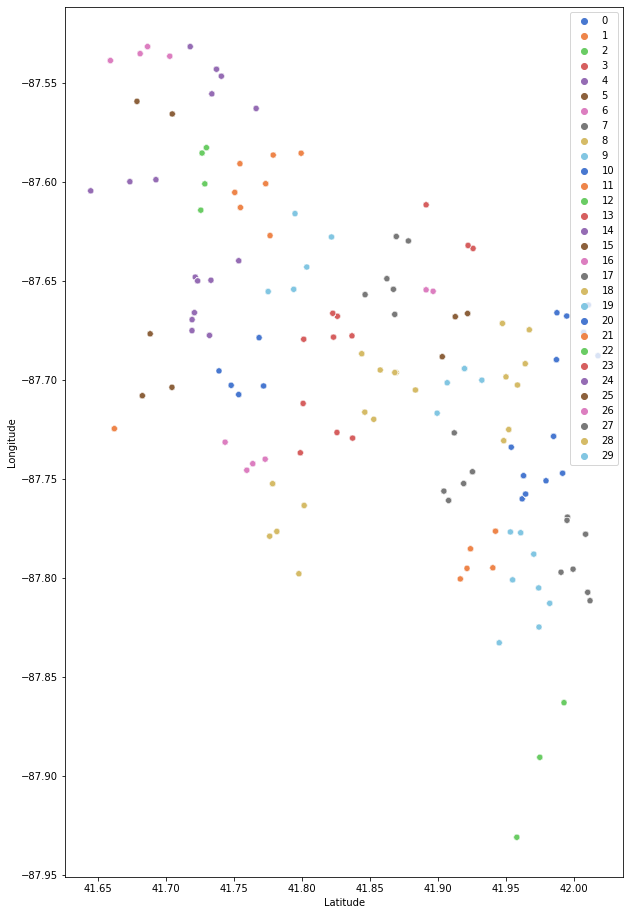

In [20]:
fig,ax=plt.subplots(1, figsize=(10,16))
sns.scatterplot(data=df_train, x='Latitude', y='Longitude', hue='trap_cluster',
                palette="muted", markers={x:x for x in range(30)})
plt.legend(loc='upper right');

**Since the algorithm has helped us to decide on the clusters and we are unable to derive further insights from how/why it has been clustered in such a manner, we will proceed to convert the clusters in dummy variables for the next stage.**

In [21]:
# convert trap clusters to dummy variables for Train data
df_train = pd.get_dummies(columns=["trap_cluster"], data=df_train, drop_first=True)

# for Test submission
df_test = pd.get_dummies(columns=["trap_cluster"], data=df_test, drop_first=True)

### Feature engineering on Weather data
- Create new column "Station" to indicate which weather station a trap is closer to
- To decide on transformation of weather features: whether to shift, apply rolling-mean or rolling-max
- Once transformation is done, add those weather features to Train set

In [22]:
# apply near_station function to Train data
df_train['Station']= df_train.apply(near_station, axis=1)

# for Test submission
df_test['Station']= df_test.apply(near_station, axis=1)

In [23]:
# Over here we apply transformation to the weather data, where k is the day lag for each weather feature.
# 3 kinds of transformation we will apply: shifting, rolling mean and rolling max

k2 = 6
weather_features_shift = {"Tmax" : k2,
                          "Tmin" : k2,
                          "Tavg" : k2,
                          "DewPoint" : k2,
                          "Sunrise" : k2,
                          "Sunset"  : k2,
                          "Day_length" : k2,
                          "PrecipTotal" : k2,
                          "ResultSpeed" : k2
                           }
    
    
k2 = 12
weather_features_rollingmean = {"Tmax" : k2,
                                "Tmin" : k2,
                                "Tavg" : k2,
                                "DewPoint" : k2,
                                "Sunrise" : k2,
                                "Sunset"  : k2,
                                "Day_length" : k2,
                                "PrecipTotal" : k2,
                                "ResultSpeed" : k2
                           }

k3 = 14
weather_features_rollingMax = {  "Tmax" : k3,  
                                 "Tmin" : k3,
                                 "Tavg" : k3,
                                 'DewPoint' :k3,
                                 "Sunrise" : k3,
                                 "Sunset"  : k3,
                                 'Day_length' : k3,
                                 'PrecipTotal' : k3,
                                 'ResultSpeed' : k3
                           }

# Over here we will create the final dataset to be used in subsequent notebooks
# We will merge the transformed weather features with the original Train data
df_final = add_weather_features(df_train, 
                                weather_features_shift,
                                weather_features_rollingmean,
                                weather_features_rollingMax)

# Do the same for the Test data
df_final_submission = add_weather_features(df_test,
                                           weather_features_shift,
                                           weather_features_rollingmean,
                                           weather_features_rollingMax)

In [24]:
df_final.shape

(10506, 86)

In [25]:
df_final.columns

Index(['Date', 'Address', 'Block', 'Street', 'Trap', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'geometry', 'year', 'month', 'week', 'day', 'year_month',
       'Station', 'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_OTHERS', 'trap_cluster_1', 'trap_cluster_2', 'trap_cluster_3',
       'trap_cluster_4', 'trap_cluster_5', 'trap_cluster_6', 'trap_cluster_7',
       'trap_cluster_8', 'trap_cluster_9', 'trap_cluster_10',
       'trap_cluster_11', 'trap_cluster_12', 'trap_cluster_13',
       'trap_cluster_14', 'trap_cluster_15', 'trap_cluster_16',
       'trap_cluster_17', 'trap_cluster_18', 'trap_cluster_19',
       'trap_cluster_20', 'trap_cluster_21', 'trap_cluster_22',
       'trap_cluster_23', 'trap_cluster_24', 'trap_cluster_25',
       'trap_cluster_26', 'trap_cluster_27', 'trap_cluster_28',
       'trap_cluster_29', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'Sunrise',
       'Sunset', 'Da

In [26]:
# one final check to see that the data is clean
df_final.isnull().sum()

Date                              0
Address                           0
Block                             0
Street                            0
Trap                              0
AddressNumberAndStreet            0
Latitude                          0
Longitude                         0
AddressAccuracy                   0
NumMosquitos                      0
WnvPresent                        0
geometry                          0
year                              0
month                             0
week                              0
day                               0
year_month                        0
Station                           0
Species_CULEX PIPIENS/RESTUANS    0
Species_CULEX RESTUANS            0
Species_OTHERS                    0
trap_cluster_1                    0
trap_cluster_2                    0
trap_cluster_3                    0
trap_cluster_4                    0
trap_cluster_5                    0
trap_cluster_6                    0
trap_cluster_7              

## Pickle data
*Back to [Contents](#Contents:)*

In [27]:
# Save neccessary object to pickle_dict, which will be pickled in next notebook for modeling
pickle_dict2 = dict()
pickle_dict2['df_train']=df_train
pickle_dict2['df_test']=df_test
pickle_dict2['df_final']=df_final
pickle_dict2['df_final_submission']=df_final_submission
pickle.dump(pickle_dict2, open('./assets/data2.pkl', 'wb'))